# Beating CAPTCHAs with Neural Networks

Interpreting information contained in images has long been a difficult problem in data mining, but it is one that is really starting to be addressed. The latest research is providing algorithms to detect and understand images to the point where automated commercial surveillance systems are now being used—in real-world scenarios—by major vendors. These systems are capable of understanding and recognizing objects and people in video footage.

It is difficult to extract information from images. There is lots of raw data in an image, and the standard method for encoding images—pixels—isn't that informative by itself. Images—particularly photos—can be blurry, too close to the targets, too dark, too light, scaled, cropped, skewed, or any other of a variety of problems that cause havoc for a computer system trying to extract useful information.

We look at extracting text from images by using neural networks for predicting each letter. The problem we are trying to solve is to automatically understand **CAPTCHA** messages. CAPTCHAs are images designed to be easy for humans to solve and hard for a computer to solve, as per the acronym: **Completely Automated Public Turing test to tell Computers and Humans Apart**. Many websites use them for registration and commenting systems to stop automated programs flooding their site with fake accounts and spam comments.

The topics covered include:
- Neural networks
- Creating our own dataset of CAPTCHAs and letters
- The scikit-image library for working with image data
- The PyBrain library for neural networks
- Extracting basic features from images
- Using neural networks for larger-scale classification tasks
- Improving performance using postprocessing

## Artificial neural networks

**Neural networks** are a class of algorithm that was originally designed based on the way that human brains work. However, modern advances are generally based on mathematics rather than biological insights. A neural network is a collection of **neurons** that are connected together. Each neuron is a simple function of its inputs, which generates an output:

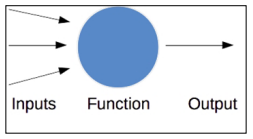

The functions that define a neuron's processing can be any standard function, such as a linear combination of the inputs, and are called the **activation function**. For the commonly used learning algorithms to work, we need the activation function to be derivable and smooth. A frequently used activation function is the logistic function, which is defined by the following equation ($k$ is often simply $1$, $x$ is the inputs into the neuron, and $L$ is normally $1$, that is, the maximum value of the function):

$$
f(x) = \frac{L}{1+e^{-k(x-x_0)}}
$$

The value of this graph, from -6 to +6, is shown as follows:

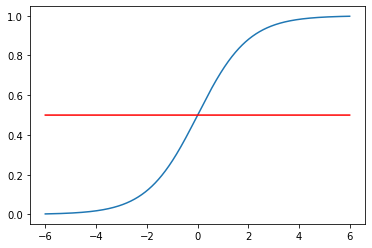

In [3]:

import numpy as np
import math
from matplotlib import pyplot as plt

%matplotlib inline

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

x = np.arange(-6, 6, 0.01)
y = np.array([sigmoid(xx) for xx in x])

plt.plot(x, y)
plt.plot(x, np.zeros(x.shape) + 0.5, color='r')

The red lines indicate that the value is **0.5** when **x** is zero.

Each individual neuron receives its inputs and then computes the output based on these values. Neural networks are simply networks of these neurons connected together, and they can be very powerful for data mining applications. The combinations of these neurons, how they fit together, and how they combine to learn a model are one of the most powerful concepts in machine learning.

## An introduction to neural networks

For data mining applications, the arrangement of neurons is usually in layers. The first layer, the **input layer**, takes the inputs from the dataset. The outputs of each of these neurons are computed and then passed along to the neurons in the next layer. This is called a **feed-forward neural network**. We will refer to these simply as neural networks for this chapter. There are other types of neural networks too that are used for different applications.

The outputs of one layer become the inputs of the next layer, continuing until we reach the final layer: the, **output layer**. These outputs represent the predictions of the neural network as the classification. Any layer of neurons between the input layer and the output layer is referred to as a **hidden layer**, as they learn a representation of the data not intuitively interpretable by humans. Most neural networks have at least *three* layers, although most modern applications use networks with many more layers than that.

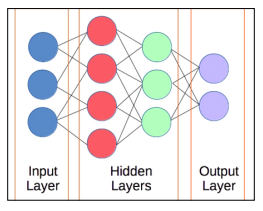

As the function of the neurons is normally the logistic function, and the neurons are fully connected to the next layer, the parameters for building and training a neural network must be other factors. The first factor for neural networks is in the building
phase: the size of the neural network. This includes how many layers the neural network has and how many neurons it has in each hidden layer (the size of the input and output layers is usually dictated by the dataset).

The second parameter for neural networks is determined in the training phase: the weight of the connections between neurons. When one neuron connects to another, this connection has an associated **weight** that is multiplied by the signal (the output of the first neuron). If the connection has a weight of 0.8, the neuron is activated, and it outputs a value of 1, the resulting input to the next neuron is 0.8. If the first neuron is not activated and has a value of 0, this stays at 0.

We now have a classifier that has initial parameters to set (the size of the network) and parameters to train from the dataset. The classifier can then be used to predict the target of a data sample based on the inputs. But first, we need a dataset to train and test with.

## Creating the dataset

In [4]:
from PIL import Image, ImageDraw, ImageFont
from skimage import transform

In [5]:
def create_captcha(text, shear=0, size=(40,20)):
    # adust size based on text lenght
    n = len(text)
    size = (n*10+20, size[1])

    #transform text to image
    text = " ".join(text)
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.load_default() 
    draw.text((2, 2), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = transform.AffineTransform(shear=shear)
    image = transform.warp(image, affine_tf)
    return image / image.max()

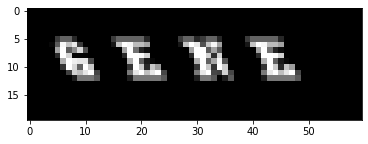

In [6]:
image = create_captcha("GENE", shear=.5)
plt.imshow(image, cmap="gray")

## Splitting the image into individual letters

Our CAPTCHAs are words. Instead of building a classifier that can identify the thousands and thousands of possible words, we will break the problem down into a smaller problem: predicting letters.

The next step in our algorithm for beating these CAPTCHAs involves segmenting the word to discover each of the letters within it. To do this, we are going to create a function that finds contiguous sections of black pixels on the image and extract them as sub-images. These are (or at least should be) our letters. First we import the label and regionprops functions, which we will use in
this function:

In [7]:
from skimage.measure import label, regionprops

def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

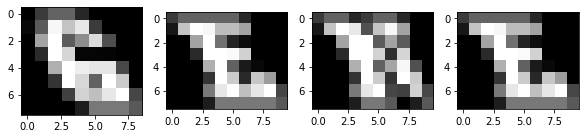

In [8]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

## Creating a training dataset

Using this function, we can now create a dataset of letters, each with different shear values! From this, we will train a neural network to recognize each letter from the image. We first set up our random state and an array that holds the options for letters and shear values that we will randomly select from. The code is as follows:

In [9]:

from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

In [10]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = str(random_state.choice(letters))
    shear = random_state.choice(shear_values)
    size = (15,15)
    target = letters.index(letter)
    return create_captcha(text=letter, shear=shear, size=size), target

The target for this image is: 14


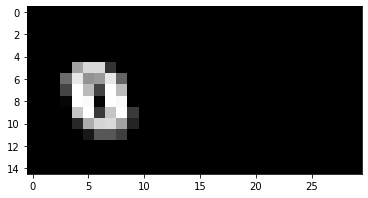

In [11]:
image, target = generate_sample()
plt.imshow(image, cmap="gray")
print(f"The target for this image is: {target}")

We can now generate all of our dataset by calling this several thousand times. We then put the data into NumPy arrays, as they are easier to work with than lists. The code is as follows:

In [12]:

dataset, targets = zip(*(generate_sample(random_state) for _ in range(3000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

Our targets are integer values between 0 and 26, with each representing a letter of the alphabet. Neural networks don't usually support multiple values from a single neuron, instead preferring to have multiple outputs, each with values 0 or 1. We therefore perform one hot-encoding of the targets, giving us a target array that has 26 outputs per sample, using values near 1 if that letter is likely and near 0 otherwise. The code is as follows:

In [13]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [14]:
y = y.todense()

## Adjusting our training dataset to our methodology

Our training dataset differs from our final methodology quite significantly. Our dataset here is nicely created individual letters, fitting the 20-pixel by 20-pixel image. The methodology involves extracting the letters from words, which may squash them, move them away from the center, or create other problems.

Ideally, the data you train your classifier on should mimic the environment it will be used in. In practice, we make concessions, but aim to minimize the differences as much as possible.

For this experiment, we would ideally extract letters from actual CAPTCHAs and label those. In the interests of speeding up the process a bit, we will just run our segmentation function on the training dataset and return those letters instead.

We will need the resize function from scikit-image, as our sub-images won't always be 20 pixels by 20 pixels.

From here, we can run our `segment_image` function on each sample and then resize them to 20 pixels by 20 pixels. Finally, we will create our dataset. This dataset array is three-dimensional, as it is an array of two-dimensional images. 

Our classifier will need a two-dimensional array, so we simply flatten the last two dimensions. Finally, using the `train_test_split` function of scikit-learn, we create a set of data for training and one for testing. The code is as follows:

In [15]:
from skimage.transform import resize

In [16]:

dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for sample in dataset])

In [17]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

## Training and classifying

We are now going to build a neural network that will take an image as input and try to predict which (single) letter is in the image.

We will use the training set of single letters we created earlier. The dataset itself is quite simple. We have a 20 by 20 pixel image, each pixel 1 (black) or 0 (white). These represent the 400 features that we will use as inputs into the neural network. The outputs will be 26 values between 0 and 1, where higher values indicate a higher likelihood that the associated letter (the first neuron is A, the second is B, and so on) is the letter represented by the input image.

## Back propagation

The back propagation (backprop) algorithm is a way of assigning blame to each neuron for incorrect predictions. Starting from the output layer, we compute which neurons were incorrect in their prediction, and adjust the weights into those neurons by a small amount to attempt to fix the incorrect prediction.

These neurons made their mistake because of the neurons giving them input, but more specifically due to the weights on the connections between the neuron and its inputs. We then alter these weights by altering them by a small amount. The amount of change is based on two aspects: 
- The partial derivative of the error function of the neuron's individual weights and the learning rate, which is a parameter to the algorithm (usually set at a very low value). 
- The gradient of the error of the function, multiply it by the learning rate, and subtract that from our weights. 

The gradient will be positive or negative, depending on the error, and subtracting the weight will always attempt to correct the weight towards the correct prediction. In some cases, though, the correction will move towards something called a **local optima**, which is better than similar weights but not the best possible set of weights.

In [19]:
import tensorflow as tf
from sklearn.metrics import f1_score

# Build the model
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(y.shape[1])
])

# Compile the model
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
net.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Make predictions
predictions = net.predict(X_test)
predictions = tf.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(predictions.numpy(), y_test.argmax(axis=1), average='weighted')
print(f"F-score: {f1:.2f}")


2024-11-25 23:51:57.335199: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
68/68 [==============================] - 1s 6ms/step - loss: 1.5577 - accuracy: 0.5931 - val_loss: 0.4089 - val_accuracy: 0.8889
Epoch 2/20
68/68 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.9782 - val_loss: 0.1292 - val_accuracy: 0.9537
Epoch 3/20
68/68 [==============================] - 0s 3ms/step - loss: 0.0590 - accuracy: 0.9926 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 4/20
68/68 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 5/20
68/68 [==============================] - 0s 3ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 6/20
68/68 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 7/20
68/68 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 8/20
68/68 [==

The score here is 0.97, which is a great result for such a relatively simple model. Recall that our features were simple pixel values only; the neural network worked out how to use them.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        13
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        14
          17       1.00    

Now that we have a classifier with good accuracy on letter prediction, we can start putting together words for our CAPTCHAs.

## Predicting words
We want to predict each letter from each of these segments, and put those predictions together to form the predicted word from a given CAPTCHA.

Our function will accept a CAPTCHA and the trained neural network, and it will return the predicted word:

In [21]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    
    for subimage in subimages:
        # Resize the subimage to (20, 20) and flatten it
        subimage = resize(subimage, (20, 20)).flatten()
        # Convert to numpy array and ensure the subimage is 2D
        subimage = np.array(subimage).reshape(1, -1)
        outputs = neural_network.predict(subimage)
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    
    return predicted_word


In [22]:
word = "GENE"
captcha = create_captcha(word, shear=0.1)
print(predict_captcha(captcha, net))

GENE


This code correctly predicts the word GENE, but makes mistakes with other words. How accurate is it? To test, we will create a dataset with a whole bunch of four-letter English words from NLTK. The code is as follows:

In [23]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [28]:
from nltk.corpus import words

In [29]:
valid_words = [word.upper() for word in words.words() if len(word) == 4]

In [30]:
import random

# Set the random state
random.seed(42)
sample = random.sample(valid_words, 1000)


In [32]:

num_correct = 0
num_incorrect = 0
for i, word in enumerate(sample):
    if i%100 == 0:
        print(f'finished {i}/{len(sample)}')
    correct, word, prediction = test_prediction(word, net, shear=0.1)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1

finished 0/1000
finished 100/1000
finished 200/1000
finished 300/1000
finished 400/1000
finished 500/1000
finished 600/1000
finished 700/1000
finished 800/1000
finished 900/1000


In [36]:
print(f"Number correct is {num_correct}")
print(f"Number incorrect is {num_incorrect}")

print(f"""
The results we get are {num_correct} correct and {num_incorrect} incorrect. An accuracy of just over {num_correct/(num_correct+num_incorrect):.2%}. 
From our original {f1:.2%} per-letter accuracy, this is a big decline. What happened?
""")

Number correct is 757
Number incorrect is 243

The results we get are 757 correct and 243 incorrect. An accuracy of just over 75.70%. 
From our original 100.00% per-letter accuracy, this is a big decline. What happened?



1. The first factor to impact is our accuracy.
2. The second impact is the shear value. Our dataset chose randomly between shear values of 0 to 0.5. The higher the shear, the lower the performance.
3. The next impact is that our letters were randomly chosen for the dataset. In reality, this is not true at all. Letters appear much more frequently than other letters.        
    - Letters that appear reasonably commonly but are frequently mistaken for each other, will also contribute to the error.

We can table which letters are frequently mistaken for each other using a confusion matrix, which is a two dimensional array. Its rows and columns each represent an individual class.

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)


Text(0, 0.5, 'True Labels')

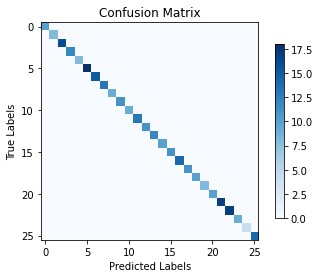

In [43]:

plt.imshow(cm, cmap="Blues")
plt.colorbar(shrink=0.8)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


In [47]:
letters_cm = {}
for i in range(cm.shape[0]):
    letters_cm[letters[i]] = cm[i][i]

print(letters_cm)


{'A': 10, 'B': 8, 'C': 16, 'D': 12, 'E': 8, 'F': 18, 'G': 15, 'H': 13, 'I': 9, 'J': 11, 'K': 9, 'L': 13, 'M': 11, 'N': 12, 'O': 10, 'P': 11, 'Q': 14, 'R': 11, 'S': 10, 'T': 8, 'U': 10, 'V': 17, 'W': 17, 'X': 9, 'Y': 4, 'Z': 14}


In [51]:
less_than_letter = None
less_than_val = None
for val in letters_cm:
    if letters_cm['U'] > letters_cm[val]:
        less_than_letter = val
        less_than_val = letters_cm[val]
        break

In [52]:
print(f"""
The letter U appears in {letters_cm['U']/100:.0%} of words in our list. 
For each word that a U appears in, we can expect this to be wrong. 
U actually appears more often than {less_than_letter} (which is in around {less_than_val/100:.0%} percent of words), 
indicating we could get a cheap (although possibly not a robust) boost in accuracy 
by changing any {less_than_letter} prediction into a U.
""")


The letter U appears in 10% of words in our list. 
For each word that a U appears in, we can expect this to be wrong. 
U actually appears more often than B (which is in around 8% percent of words), 
indicating we could get a cheap (although possibly not a robust) boost in accuracy 
by changing any B prediction into a U.



## Improving accuracy using a dictionary

Rather than just returning the given prediction, we can check whether the word actually exists in our dictionary. If it does, then that is our prediction. If it isn't in the dictionary, we can try and find a word that is similar to it and predict that instead. 

#### Note that this strategy relies on our assumption that all CAPTCHA words will be valid English words, and therefore this strategy wouldn't work for a random sequence of characters. This is one reason why some CAPTCHAs don't use words.

There is one issue here—how do we determine the closest word? There are many ways to do this. For instance, we can compare the lengths of words. Two words that have a similar length could be considered more similar. However, we commonly consider words to be similar if they have the same letters in the same positions. This is where the edit distance comes in.

## Ranking mechanisms for words
The **Levenshtein edit distance** is a commonly used method for comparing two short strings to see how similar they are. It isn't very scalable, so it isn't commonly used for very long strings. The edit distance computes the number of steps it takes to go from one word to another. The steps can be one of the following three actions:

1. Insert a new letter into the word at any position.
2. Delete any letter from the word.
3. Substitute a letter for another one.

The minimum number of actions needed to transform the first word into the second is given as the distance. Higher values indicate that the words are less similar.

In [53]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print(f"The number of steps needed is: {steps}")

The number of steps needed is: 1


When used with different words, the edit distance is quite a good approximation to what many people would intuitively feel are similar words. The edit distance is great for testing spelling mistakes, dictation errors, and name matching (where you can mix up your Marc and Mark spelling quite easily).

However, it isn't very good. We don't really expect letters to be moved around, just individual letter comparisons to be wrong. For this reason, we will create a different distance metric, which is simply the number of letters in the same positions that are incorrect. The code is as follows:

In [54]:
def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == word[i] for i in range(len(prediction)))

## Putting it all together
We can now test our improved prediction function using similar code to before. First we define a prediction, which also takes our list of valid words:

In [ ]:
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.1):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    if prediction not in dictionary:
        distances = sorted([(word, 
                             compute_distance(prediction, word)) for word in dictionary],
                             key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [60]:
num_correct = 0
num_incorrect = 0
for i, word in enumerate(sample):
    if i%100 == 0:
        print(f'finished {i}/{len(sample)}')
    correct, word, prediction = improved_prediction (word, net, sample, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print(f"Number correct is {num_correct}")
print(f"Number incorrect is {num_incorrect}")

print(f"""
The results we get are {num_correct} correct and {num_incorrect} incorrect. An accuracy of just over {num_correct/(num_correct+num_incorrect):.2%}. 
From our original {f1:.2%} per-letter accuracy, this is a big decline. What happened?
""")

finished 0/1000
finished 100/1000
finished 200/1000
finished 300/1000
finished 400/1000
finished 500/1000
finished 600/1000
finished 700/1000
finished 800/1000
finished 900/1000
Number correct is 639
Number incorrect is 361

The results we get are 639 correct and 361 incorrect. An accuracy of just over 63.90%. 
From our original 100.00% per-letter accuracy, this is a big decline. What happened?



To further improve the results, we can work on our distance metric, perhaps using information from our confusion matrix to find commonly confused letters or some other improvement upon this. This iterative improvement is a feature of many data mining methodologies, and it mimics the scientific method—have an idea, test it out, analyze the results, and use that to improve the next idea.